<img src="https://github.com/d9w/evolution/raw/master/imgs/logo.png" width="20%" align="right" style="margin:0px 20px">


# Evolutionary Computation

## 1.3 Evolutionary Algorithms

<a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/"><img alt="Creative Commons License" align="left" src="https://i.creativecommons.org/l/by-sa/4.0/80x15.png" /></a>&nbsp;| Dennis G. Wilson | <a href="https://d9w.github.io/evolution/">https://d9w.github.io/evolution/</a>

## Outline

1. [Individuals](#individuals)
2. [Objectives](#objectives)
3. [(1+1) EA](#one_plus_one)
4. [$(1+\lambda)$ EA](#one_plus_lambda)
5. [Algorithm parameters](#parameters)


[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/d9w/evolution/blob/master/1_introduction/evolutionary_algorithms.ipynb)

In [90]:
%matplotlib inline
import matplotlib.pyplot as plt
import math
import numpy as np
from tqdm import tqdm
np.random.seed(1234)

## <a id="individuals"></a>Individuals

The base unit of an evolutionary algorithm is the individual. An individual represents a single solution to the problem we want to solve. We'll start simple with binary individuals, where genes are represented by bits. DNA in biological organisms is mostly base 4, being represented by 4 different amino acids. We'll use a base 2 representation of 1s and 0s, but the interpretation of these binary strings could lead to any complex organism. Using binary strings allows us to discuss the theoretical analysis of evolutionary algorithms, which have mostly been studied on binary genomes.

In [91]:
class Individual:
    
    def __init__(self, n: int):
        self.genes = np.random.randint(0, 2, (n,))
        self.fitness = -np.inf
        
    def __str__(self):
        return f'(Ind: {self.genes}, {self.fitness})'
    
    def __repr__(self):
        return str(self)

Here we've defined a new type, `Individual` which has binary genes and an integer fitness. When we construct a new individual, we use random genes and set the default fitness to 0. For these examples we'll be using objective functions which have positive fitness values.

In [92]:
ind = Individual(10)
ind

(Ind: [1 1 0 1 0 0 0 1 1 1], -inf)

## <a id="objectives"></a>Objectives

An objective function is a function which gives a value to our individual. A strength of evolutionary algorithms is that this objective function can be anything as long as it evaluates the individual. Unlike other optimization methods, this function does not need to be differentiable or continuous. The first objective function we'll look at is the OneMax function, which simply adds all of the bits of the genotype. The optimal fitness for this function is therefore when the entire genotype is 1. This simple function has been well-studied and generalizes well to the search of any specific bit string.

In [93]:
def onemax(i: Individual):
    return np.sum(i.genes)

In [94]:
ind.fitness = onemax(ind)
ind

(Ind: [1 1 0 1 0 0 0 1 1 1], 6)

As we can see, the fitness of our individual is the number of 1s in the function.

In order to be more general later, we'll write an `evaluate` function which can take any `objective` function. The `!` exclamation point in `evaluate!` indicates that this function modifies the object which is passed. 

In [95]:
def evaluate(ind: Individual, objective):
    ind.fitness = objective(ind)

evaluate(ind, onemax)
ind

(Ind: [1 1 0 1 0 0 0 1 1 1], 6)

Now that we have our individuals defined and we have an objective function, we're ready to write our first evolutionary algorithm.

## <a id="one_plus_one"></a>(1+1) Evolutionary Algorithm

The first algorithm we'll implement is the simplest evolutionary algorithm, the (1+1) Evolutionary Algorithm:

1. Choose randomly an initial bit string $x∈ \{0;1\} $
2. Repeat the following mutation step:
    1. Compute $x′$ by flipping independently each bit $x_i$ with probability $p$
    2. Replace $x$ by $x′$ if $f(x′) \geq f(x)$.

We'll start by defining the number of dimensions for our problem, then define the first individual, the starting point of search.

In [96]:
n = 20

In [97]:
parent = Individual(n)
evaluate(parent, onemax)

Let's define the mutation step as a function. This will make our code more organized and has the advantage in Julia that compilation will optimize this part of the code. We'll use the probability of $p=\frac{1}{n}$, where $n$ is the number of bits. We'll discuss that choice soon.

In [98]:
def mutate(ind: Individual, mutation_rate=1.0/len(ind.genes)):
    new_genes = np.copy(ind.genes)
    for i in range(len(new_genes)):
        if np.random.rand() < mutation_rate:
            new_genes[i] = not ind.genes[i]
    child = Individual(len(ind.genes))
    child.genes = new_genes
    return child

In [99]:
child = mutate(parent)
print("Parent :", parent)
print("Child :", child)
print("Genes :", parent.genes == child.genes)

Parent : (Ind: [1 1 0 0 1 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0], 6)
Child : (Ind: [1 1 1 0 1 0 0 1 0 0 0 0 0 0 1 0 1 1 0 0], -inf)
Genes : [ True  True False  True  True  True  True False  True  True  True  True
  True  True  True  True  True  True  True  True]


Try running this a few times and you'll see that most of the time, only one gene changes. That makes sense due to the $p=\frac{1}{n}$ mutation rate we set. This means that evolution will move rather slowly towards the optimal bitstring, on average only 1 change at a time.

Now that we have the new individual, we can do the last part of our algorithm: Replace $x$ by $x′$ if $f(x′) \geq f(x)$. To do this, we must first evaluate the new individual.

In [100]:
evaluate(child, onemax)
print(parent.fitness)
print(child.fitness)
if child.fitness >= parent.fitness:
    parent = child
parent.fitness

6
8


8

That's all there is to the (1+1) EA. We simply run this mutation step over and over until we reach the solution we want or stop the computation. Let's look at just a few iterations:

In [101]:
parent = Individual(n)
for i in range(20):
    child = mutate(parent)
    evaluate(child, onemax)
    if child.fitness >= parent.fitness:
        parent = child
    # print(i, " ", parent.fitness)

print(parent.fitness, " / ", n)

15  /  20


So in a few generations, we can see improvement. To study how long it will take for this to reach the OneMax solution, let's first define everything we've done until now as a function.

In [102]:
def one_plus_one(ind_length: int, num_generations: int, objective, mutation_rate=1/len(ind.genes)):
    fits = np.zeros(num_generations)
    parent = Individual(ind_length)
    evaluate(parent, objective)
    
    for i in tqdm(range(len(fits))):
        child = mutate(parent, mutation_rate)
        evaluate(child, objective)

        if child.fitness >= parent.fitness:
            parent = child
            
        fits[i] = parent.fitness
    return fits

Since evolutionary algorithms are stochastic, it's hard to guarantee their exact computational complexity. You can prove the worst case, but a more useful metric is the expected number of generations to reach the optimal solution. For linear objective functions such as the OneMax problem, the expected runtime for the (1+1) EA has been [proven](https://core.ac.uk/download/pdf/82100186.pdf) to to be $0(n \log n)$, where $n$ is the number of independent binary variables (ie, the length of the genome). This proof is beyond the scope of this class, but I recommend looking at the linked publications in this notebook. Note that this is only for the case of a mutation rate of $\frac{1}{n}$, which is why we used it as our default value before. 

Let's run our (1+1) EA with $n \log n$ as our number of generations.

In [103]:
n = 1000
fits = one_plus_one(n, int(np.round(n * np.log(n)))*2, onemax)
print(fits[-1])

100%|██████████| 13816/13816 [00:07<00:00, 1942.13it/s]

663.0


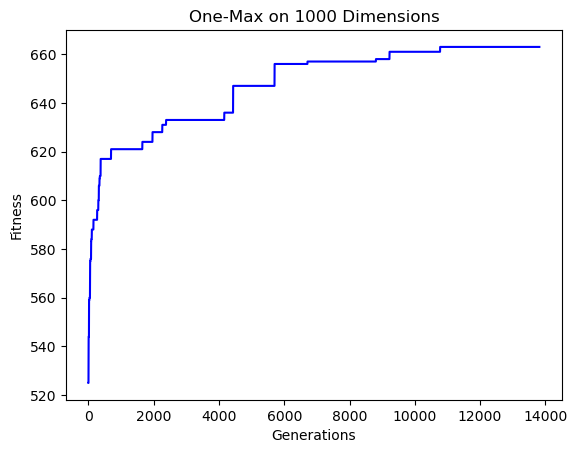

In [104]:
plt.plot(fits, 'b')
plt.xlabel("Generations")
plt.ylabel("Fitness")
plt.title(f"One-Max on {n} Dimensions");

This isn't yet $n$ but its very close, which is what the expected time guarantees: $n \log n$ is the average value of when the (1+1) EA converges. The worst case for a binary (1+1) EA on any function is to converge in $O(n^n)$, but we don't need to run it for that long to see convergence.

The Leading Ones problem is another well-studied binary problem which counts the number of leading ones from left to right, stopping when the first zero-bit is found. In other words, the fitness of this function is:

$f(x) := \sum_{i=1}^n \prod_{j=1}^i x_j$

In our implementation, we'll just count the indices and stop when we reach a 0.

In [105]:
def leading_ones(ind: Individual):
    f = 0
    for i in range(len(ind.genes)):
        if not ind.genes[i]:
            f = i
            break
    return f
print(ind)
leading_ones(ind)

(Ind: [1 1 0 1 0 0 0 1 1 1], 6)


2

<div class="alert alert-success">
    <b>Exercise</b>
    <br/>
    Run the (1+1) EA on the Leading Ones problem. Does it converge near $0(n \log n)$, or $O(n^2)$?
    <br/>
</div>

## <a id="one_plus_lambda"></a>$(1+\lambda)$ Evolutionary Algorithm

The next algorithm that we'll see is a small change on the (1+1) EA. Instead of generating one individual each iteration (generation) we'll make $\lambda$. This can be considered our population. This small change means the $(1+\lambda)$ algorithm is still very simple, but this simple algorithm is used in state-of-the-art Genetic Programming methods to do perform complex tasks.

The $(1+\lambda) EA$ introduces a new parameter: population size. What should we choose for this parameter? [Recent theoretical work](https://www.sciencedirect.com/science/article/pii/S0304397514002060) has demonstrated that the expected running time of the $(1+\lambda)$ EA on any linear function is $O(\frac{1}{λ} n \log n + n)$ under the condition that $\lambda = O(\log n \log \log n / \log \log \log n)$. We could try that.

In [106]:
n = 1000
𝜆 = int(round(np.log(n)*np.log(np.log(n))/np.log(np.log(np.log(n)))))
print(𝜆)

20


We'll rewrite our `one_plus_one` function, this time using a population of individuals. We'll keep track of the best new individual in order to compare it with the expert for replacement in the next generation.

In [107]:
m = 1
a = [0]
for i in range(1, m+1):
    a.append(i)
print(a)

[0, 1]


In [108]:
def one_plus_lambda(ind_length: int, num_generations: int, objective, 𝜆: int, mutation_rate=1/len(ind.genes)):
    fits = np.zeros(num_generations)
    expert = Individual(ind_length)
    evaluate(expert, objective)
    
    for i in tqdm(range(len(fits))):
        population = [expert,]
        best = 0
        for j in range(1, 𝜆):
            population.append(mutate(expert, mutation_rate))
            evaluate(population[j], objective) 
            if population[j].fitness > population[best].fitness:
                best = j
        if population[best].fitness >= expert.fitness:
            expert = population[best]
        fits[i] = expert.fitness
    return fits

Let's see how these two methods compare on the OneMax problem.

In [109]:
n = 100
n_gens = 1000
fits_1 = one_plus_one(n, n_gens, onemax)
fits_𝜆 = one_plus_lambda(n, n_gens, onemax, 𝜆)
fits_1[-1], fits_𝜆[-1]

100%|██████████| 1000/1000 [00:00<00:00, 1303.23it/s]


(87.0, 93.0)

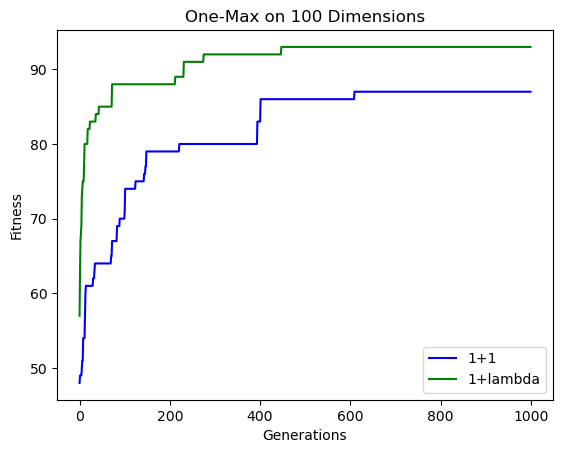

In [110]:
plt.plot(fits_1, label="1+1", color='b')
plt.plot(fits_𝜆, label="1+lambda", color='g')
plt.xlabel("Generations")
plt.ylabel("Fitness")
plt.title(f"One-Max on {n} Dimensions")
plt.legend();

At first glance, it appears that the $(1+\lambda)$ EA performs much better than the (1+1) EA. However, this is an unfair comparison. The $(1+\lambda)$ EA runs the evaluation function $\lambda$ times per generation, meaning there are many more evaluations. We can see this by plotting based on evaluation.

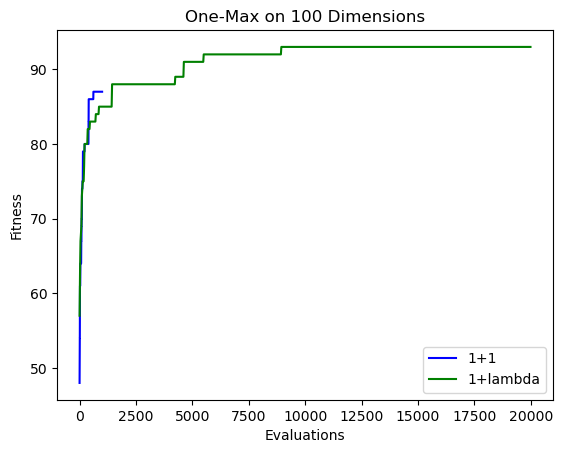

In [111]:
plt.plot(fits_1, label="1+1", color='b')
plt.plot(np.arange(1,n_gens*𝜆,𝜆), fits_𝜆, label="1+lambda", color='g')
plt.xlabel("Evaluations")
plt.ylabel("Fitness")
plt.title(f"One-Max on {n} Dimensions")
plt.legend();

A more fair comparison would be to give each algorithm the same number of function evaluations, like this:

In [112]:
n = 1000
n_gens = 10000
fits_1 = one_plus_one(n, n_gens, onemax)
fits_𝜆 = one_plus_lambda(n, int(n_gens/𝜆), onemax, 𝜆)

100%|██████████| 500/500 [00:02<00:00, 170.35it/s]


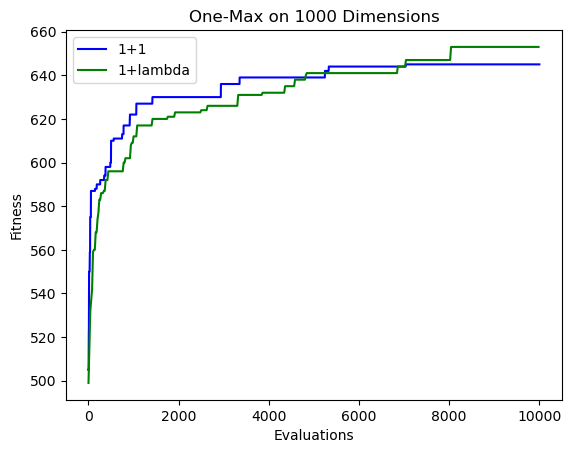

In [113]:
plt.plot(fits_1, label="1+1", color='b')
plt.plot(np.arange(1,n_gens,𝜆), fits_𝜆, label="1+lambda", color='g')
plt.xlabel("Evaluations")
plt.ylabel("Fitness")
plt.title(f"One-Max on {n} Dimensions")
plt.legend();

Because evolutionary algorithms are entirely based on randomness, it is a good practice to run them multiple times to have an idea about their performance. We'll run this 10 times, but more is often a good idea, depending on the distribution of final results.

In [114]:
n_trials = 100
n = 100
n_gens = 1000

fits_1 = np.zeros((n_gens, n_trials))
fits_𝜆 = np.zeros((int(n_gens/𝜆), n_trials))

for i in range(n_trials):
    fits_1[:, i] = one_plus_one(n, n_gens, onemax)
    fits_𝜆[:, i] = one_plus_lambda(n, int(n_gens/𝜆), onemax, 𝜆)

100%|██████████| 50/50 [00:00<00:00, 1284.44it/s]


In [115]:
μ_1 = np.mean(fits_1, axis=1)
σ_1 = np.std(fits_1, axis=1)
μ_𝜆 = np.mean(fits_𝜆, axis=1)
σ_𝜆 = np.std(fits_𝜆, axis=1)
print(np.shape(μ_1), np.shape(σ_1))
print(np.shape(μ_𝜆), np.shape(σ_𝜆))

(1000,) (1000,)
(50,) (50,)


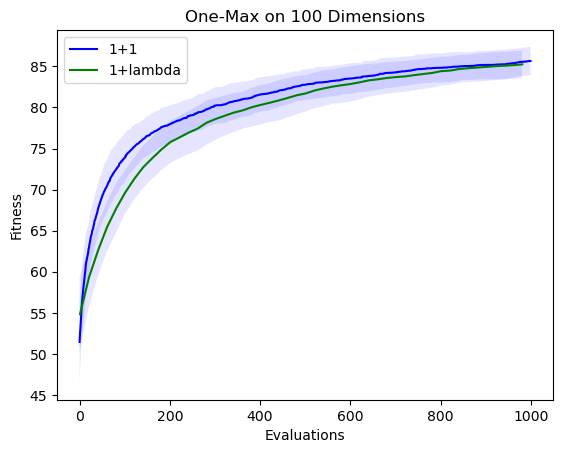

In [116]:
plt.plot(μ_1, label="1+1", color='b')
plt.fill_between(np.arange(0, n_gens), μ_1+σ_1, μ_1-σ_1, facecolor='b', alpha=0.1)
plt.plot(np.arange(1,n_gens,𝜆), μ_𝜆, label="1+lambda", color='g')
plt.fill_between(np.arange(0, n_gens, 𝜆), μ_𝜆+σ_𝜆, μ_𝜆-σ_𝜆, facecolor='b', alpha=0.1)
plt.xlabel("Evaluations")
plt.ylabel("Fitness")
plt.title(f"One-Max on {n} Dimensions")
plt.legend();

<div class="alert alert-success">
    <b>Exercise</b>
    <br/>
    Compare the (1+1) EA and $(1+\lambda)$ EA on the Leading Ones problem
    <br/>
</div>

In [124]:
n_trials = 100
n = 100
n_gens = 1000
𝜆 = 20

fits_1 = np.zeros((n_gens, n_trials))
fits_𝜆 = np.zeros((int(n_gens/𝜆), n_trials))

for i in range(n_trials):
    fits_1[:, i] = one_plus_one(n, n_gens, leading_ones)
    fits_𝜆[:, i] = one_plus_lambda(n, int(n_gens/𝜆), leading_ones, 𝜆)

100%|██████████| 50/50 [00:00<00:00, 1363.49it/s]


In [125]:
μ_1 = np.mean(fits_1, axis=1)
σ_1 = np.std(fits_1, axis=1)
μ_𝜆 = np.mean(fits_𝜆, axis=1)
σ_𝜆 = np.std(fits_𝜆, axis=1)
print(np.shape(μ_1), np.shape(σ_1))
print(np.shape(μ_𝜆), np.shape(σ_𝜆))

(1000,) (1000,)
(50,) (50,)


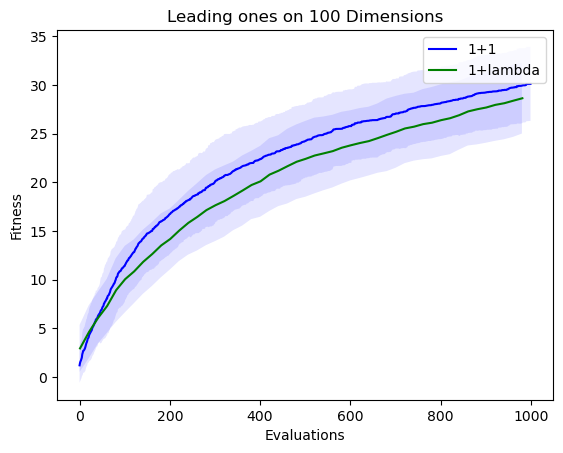

In [126]:
plt.plot(μ_1, label="1+1", color='b')
plt.fill_between(np.arange(0, n_gens), μ_1+σ_1, μ_1-σ_1, facecolor='b', alpha=0.1)
plt.plot(np.arange(1,n_gens,𝜆), μ_𝜆, label="1+lambda", color='g')
plt.fill_between(np.arange(0, n_gens, 𝜆), μ_𝜆+σ_𝜆, μ_𝜆-σ_𝜆, facecolor='b', alpha=0.1)
plt.xlabel("Evaluations")
plt.ylabel("Fitness")
plt.title(f"Leading ones on {n} Dimensions")
plt.legend();

It seems that the 1+lambda is less performing than the 1+1 EA for the leading ones problem too.

## <a id="parameters"></a>Algorithm parameters

In this tutorial, we used fixed parameter values based on theoretical results. However, in practice, the choice of mutation rate and population size can greatly impact experimental results. Recent work has also demonstrated the value in [self-adjusting parameters](https://arxiv.org/pdf/1704.02191.pdf), which is similar to what a different stochastic optimization method, simulated annealing, uses. The policy of parameter adjustment is still an active field of research.

<div class="alert alert-info">
    <b>Bonus Exercise</b>
    <br/>
    Study the effect of population size $\lambda$ and mutation rate on $(1+1)$ EA and $(1+\lambda)$ EA. Do they change the results a lot? Try implementing a dynamic mutation rate, such as one that decreases over time.
    <br/>
</div>

In [134]:
# Define the range of lambda values to test
lambda_values = [5, 10, 20, 50, 100]

# Define the number of generations
num_generations = 1000

# Define the length of the individual
ind_length = 100

# Run the (1+1) and (1+lambda) EA for each lambda value
fits_1 = []
fits_𝜆 = []

for 𝜆 in lambda_values:
    fits_1.append(one_plus_one(ind_length, num_generations, onemax))
    fits_𝜆.append(one_plus_lambda(ind_length, int(num_generations/𝜆), onemax, 𝜆))

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:00<00:00, 151.12it/s]


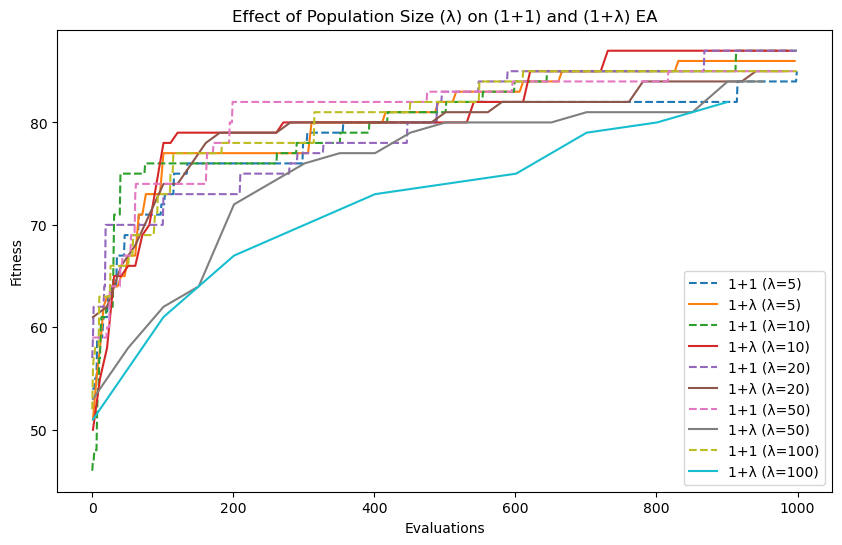

In [135]:
# Plot the fitness improvement over generations for each lambda value
plt.figure(figsize=(10, 6))
for i, 𝜆 in enumerate(lambda_values):
    plt.plot(fits_1[i], label=f"1+1 (λ={𝜆})", linestyle='--')
    plt.plot(np.arange(1,num_generations,𝜆),fits_𝜆[i], label=f"1+λ (λ={𝜆})")

plt.xlabel("Evaluations")
plt.ylabel("Fitness")
plt.title("Effect of Population Size (λ) on (1+1) and (1+λ) EA")
plt.legend()
plt.show()

In [122]:
mutation_rates = [0.005, 0.01, 0.05, 0.1, 0.2, 0.5]
n_trials = 100
n_gens = 1000

fits_1 = []
fits_𝜆 = []

for rate in mutation_rates:
    fits_1_rate = []
    fits_𝜆_rate = []
    
    for _ in range(n_trials):
        fits_1_trial = one_plus_one(n, n_gens, onemax, mutation_rate=rate)[-1]
        fits_𝜆_trial = one_plus_lambda(n, int(n_gens/𝜆), onemax, 𝜆, mutation_rate=rate)[-1]
        
        fits_1_rate.append(fits_1_trial)
        fits_𝜆_rate.append(fits_𝜆_trial)
    
    fits_1.append(fits_1_rate)
    fits_𝜆.append(fits_𝜆_rate)

100%|██████████| 10/10 [00:00<00:00, 216.85it/s]


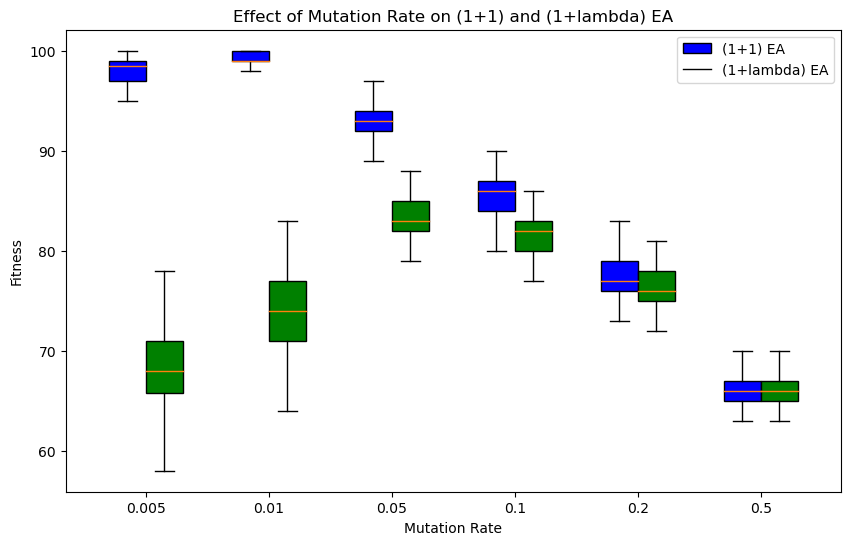

In [123]:
plt.figure(figsize=(10, 6))
plt.boxplot(fits_1, positions=np.arange(len(mutation_rates))-0.15, widths=0.3, showfliers=False, patch_artist=True, boxprops=dict(facecolor='b'))
plt.boxplot(fits_𝜆, positions=np.arange(len(mutation_rates))+0.15, widths=0.3, showfliers=False, patch_artist=True, boxprops=dict(facecolor='g'))
plt.xticks(np.arange(len(mutation_rates)), mutation_rates)
plt.xlabel("Mutation Rate")
plt.ylabel("Fitness")
plt.title("Effect of Mutation Rate on (1+1) and (1+lambda) EA")
plt.legend(["(1+1) EA", "(1+lambda) EA"])
plt.show()